#Audio Analysis and Classification

We are going to use the <a href='https://www.tensorflow.org/datasets/catalog/speech_commands'>Speech Commands</a> dataset and try to classify them into the words that they are trying to say. This will be achieved by analysis of the spectrogram of the audio samples using a CNN model.

### Importing Libraries

In [1]:
import os, pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

###Importing the dataset

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )

182083584/182082353 [==============================] - 5s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands: ', commands)

Commands:  ['stop' 'up' 'left' 'no' 'go' 'right' 'yes' 'down']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Num of total samples: ', num_samples)
print('Num of samples per label: ', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor: ', filenames[0])

Num of total samples:  8000
Num of samples per label:  1000
Example file tensor:  tf.Tensor(b'data/mini_speech_commands/down/6b7d5101_nohash_0.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400:7200]
test_files = filenames[-800:]

print('Train size: ', len(train_files))
print('Val size: ', len(val_files))
print('Test size: ', len(test_files))

Train size:  6400
Val size:  800
Test size:  800


###Reading audio files and their labels

We will be decooding the audio files. These files are in WAV format which contains information like the amplitude at each timestep. The sample rate will be 16kHz and tf.audio.decode_wav will normalize the values to the range -1.0 to 1.0

In [6]:
def decode_audio(audio_bin):
    audio, _ = tf.audio.decode_wav(audio_bin)
    return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [8]:
def get_waveform_label(file_path):
    label = get_label(file_path)
    audio_bin = tf.io.read_file(file_path)
    waveform = decode_audio(audio_bin)
    return waveform, label

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTOTUNE)

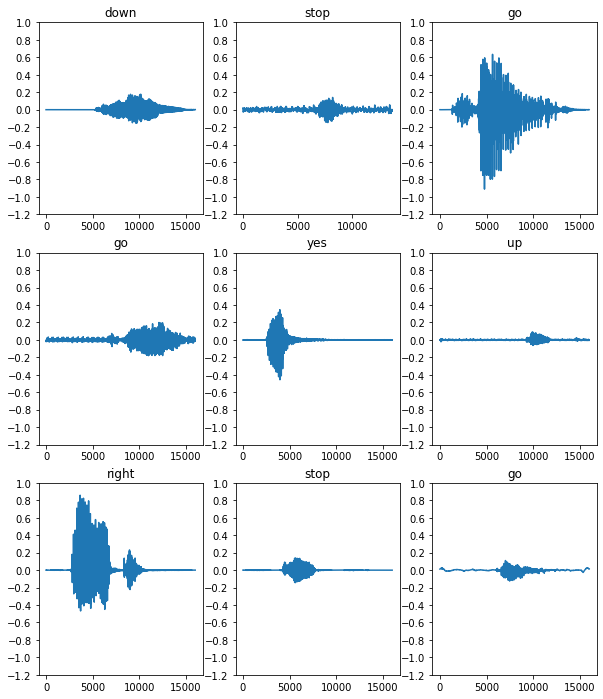

In [10]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10,12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i//cols
    c = i%cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2,1.2,0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

###Converting the waveforms to a spectrogram

We can convert the amplitude waveforms into a frequency distribution called a spectrogram by applying STFT- Short Time Fourier Transform. A simple fourier transform is not used because all the time information will be lost in that step. STFT applies fourier transform on time windows and returns a 2D image that we can run convolutions on. STFT gives us magnitude as well as phase. We will only be using the magnitude here.

In [11]:
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # adding zero padding to all the audio clips to make them of the same size
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [12]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label: ', label)
print('Waveform Shape: ', waveform.shape)
print('Spectrogram shape: ', spectrogram.shape)
print('\nAudio Playback:')
display.display(display.Audio(waveform, rate=16000))

Label:  down
Waveform Shape:  (16000,)
Spectrogram shape:  (124, 129)

Audio Playback:


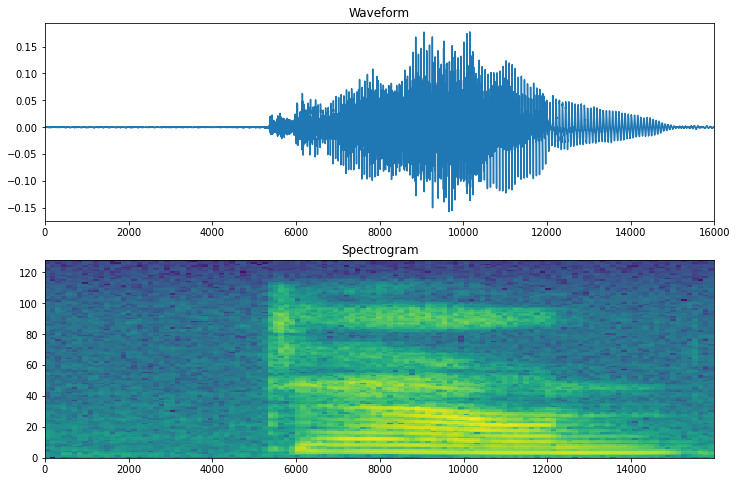

In [13]:
def plot_spectrogram(spectrogram, ax):
    #taking log of frequencies and transposing to represent in x-axis
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(16000, step=height+1)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [14]:
def get_spectrogram_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(get_spectrogram_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


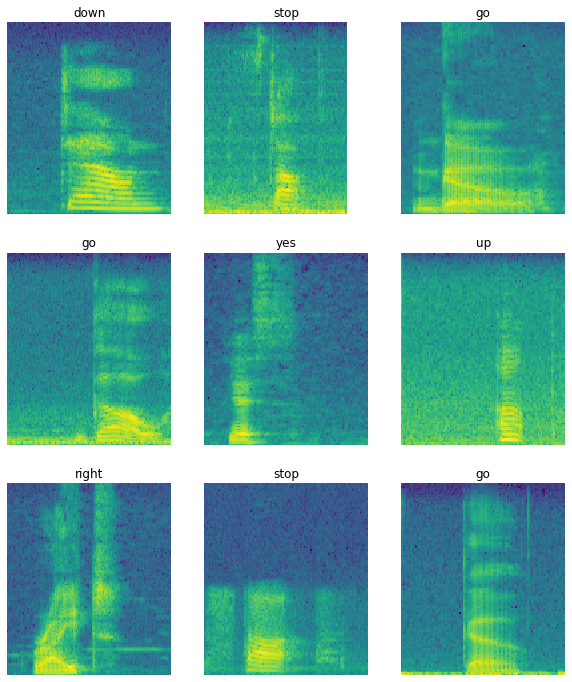

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10,12))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i//cols
    c = i%cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
plt.show()

###Build and train the CNN model

In [18]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [19]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [20]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input Shape: ', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x)) #making the norm layer adapt to the spectrogram for aggregate stats

model = models.Sequential([
                           layers.Input(shape=input_shape),
                           preprocessing.Resizing(32, 32),
                           norm_layer,
                           layers.Conv2D(32, 3, activation='relu'),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.25),
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dropout(0.5),
                           layers.Dense(num_labels)
])

model.summary()

Input Shape:  (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)           

In [25]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [26]:
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
100/100 [==============================] - 21s 140ms/step - loss: 1.9405 - accuracy: 0.2751 - val_loss: 1.2513 - val_accuracy: 0.5850
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.2812 - accuracy: 0.5472 - val_loss: 0.8781 - val_accuracy: 0.7188
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.9685 - accuracy: 0.6572 - val_loss: 0.7803 - val_accuracy: 0.7487
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.7947 - accuracy: 0.7156 - val_loss: 0.6395 - val_accuracy: 0.7925
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.6889 - accuracy: 0.7538 - val_loss: 0.6371 - val_accuracy: 0.7788
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.6215 - accuracy: 0.7803 - val_loss: 0.5843 - val_accuracy: 0.7962
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.5322 - accuracy: 0.8095 - val_loss: 0.5557 - val_accuracy: 0.8112
Epo

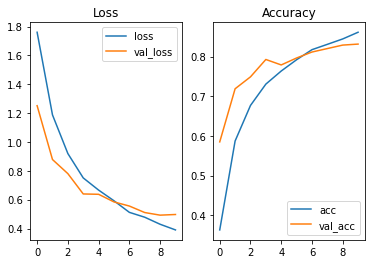

In [32]:
metrics = history.history
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.title('Loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1,2,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy');

###Evaluate performance on test set

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'The accuracy on the test data is: {test_acc:.0%}')

The accuracy on the test data is: 82%


####Display a confusion matrix

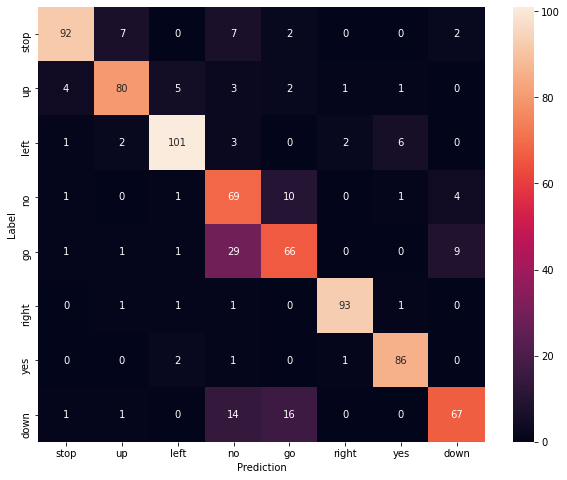

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label');

###Running inference on audio files

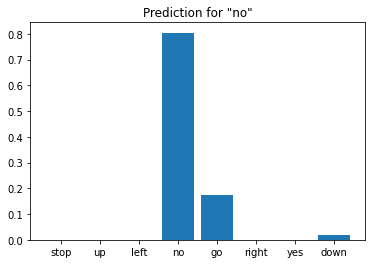

In [47]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    pred = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(pred[0]))
    plt.title(f'Prediction for "{commands[label[0]]}"');